In [21]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.distributions.normal import Normal
import torch.multiprocessing as mp

import gymnasium as gym

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
plt.rcParams["figure.figsize"] = (10, 5)

cpu


In [22]:
import os
from model.Reinforce import REINFORCE

def mkdir(path): 
    if not os.path.exists(path):
        os.mkdir(path)

seed_set = [1]
env_name = "InvertedPendulum-v4"

save_path = ".\save"
env_path = f'{save_path}\{env_name}'
model_path = f'{save_path}\{env_name}\model'
demo_path = f'{save_path}\{env_name}\demo'

mkdir(save_path)
mkdir(env_path)
mkdir(model_path)
mkdir(demo_path)


In [23]:
# Create and wrap the environment
env = gym.make(env_name)
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)  # Records episode-reward

total_num_episodes = 100  # Total number of episodes
# Observation-space of InvertedPendulum-v4 (4)
obs_space_dims = env.observation_space.shape[0]
# Action-space of InvertedPendulum-v4 (1)
action_space_dims = env.action_space.shape[0]
rewards_over_seeds = []

for seed in seed_set:  # Fibonacci seeds
    # set seed
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    # Reinitialize agent every seed
    agent = REINFORCE(obs_space_dims, action_space_dims, device = device)
    reward_over_episodes = []

    for episode in range(total_num_episodes):
        # gymnasium v26 requires users to set seed while resetting the environment
        obs, info = wrapped_env.reset(seed=seed)

        done = False
        while not done:
            action = agent.sample_action(obs)

            # Step return type - `tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]`
            # These represent the next observation, the reward from the step,
            # if the episode is terminated, if the episode is truncated and
            # additional info from the step
            obs, reward, terminated, truncated, info = wrapped_env.step(action)
            agent.rewards.append(reward)

            # End the episode when either truncated or terminated is true
            #  - truncated: The episode duration reaches max number of timesteps
            #  - terminated: Any of the state space values is no longer finite.
            done = terminated or truncated

        reward_over_episodes.append(wrapped_env.return_queue[-1])
        agent.update()

        if episode % 1000 == 0:
            avg_reward = int(np.mean(wrapped_env.return_queue))
            print("Episode:", episode, "Average Reward:", avg_reward)

    rewards_over_seeds.append(reward_over_episodes)

    save_model = f'{model_path}\{env_name}.pth'
    torch.save(agent, save_model)
    

Episode: 0 Average Reward: 8


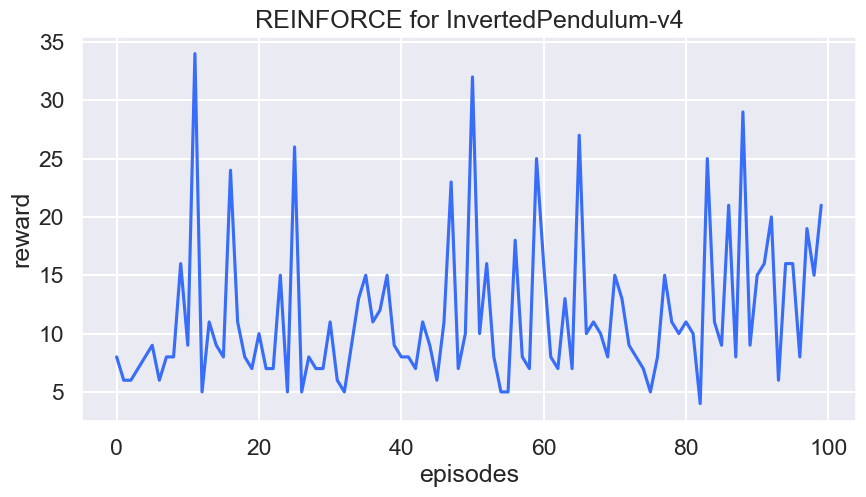

In [24]:
rewards_to_plot = [[reward[0] for reward in rewards] for rewards in rewards_over_seeds]
df1 = pd.DataFrame(rewards_to_plot).melt()
df1.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df1).set(
    title="REINFORCE for InvertedPendulum-v4"
)
plt.show()

In [27]:
import gymnasium as gym
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
%matplotlib inline

# Function to visualize the trained model
def visualize_trained_model(agent, env_name="InvertedPendulum-v4", num_episodes=1, seed=1):
    env = gym.make(env_name, render_mode='rgb_array')
    frames = []
    
    # Set seed for reproducibility
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    for episode in range(num_episodes):
        obs, info = env.reset(seed=seed)
        done = False
        while not done:
            frame = env.render()
            frames.append(frame)
            action = agent.sample_action(obs)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
    
    env.close()

    # Create animation
    fig = plt.figure()
    plt.axis('off')
    im = plt.imshow(frames[0])

    def update(frame):
        im.set_array(frame)
        return [im]

    ani = FuncAnimation(fig, update, frames=frames, interval=50)
    plt.close()
    display(HTML(ani.to_jshtml()))

    frames = [Image.fromarray(frame) for frame in frames]
    frames[0].save(f'{demo_path}\{env_name}.gif', save_all=True, append_images=frames[1:], loop=0, duration=50)
    return ani

# Assuming the REINFORCE class and agent are defined and trained as in your provided code
visualize_trained_model(agent, env_name="InvertedPendulum-v4")

    



MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: .mp4